# Miniproyecto 4

En este Jupyter Notebook pueden implementar los códigos necesarios para resolver el **Miniproyecto 4**.

**Importante:** Recuerden que, como grupo, deben **adjuntar el código** en su entrega.

Tengan en cuenta que Coursera utiliza recursos compartidos entre todos los grupos, por lo tanto, si hay muchos equipos trabajando al mismo tiempo, los procesos pueden demorar más de lo previsto.

Pueden agregar todas las celdas de código que consideren necesarias para resolver el miniproyecto. **No hay un límite en este aspecto.**

# Clasificación de Sonidos de la Naturaleza usando el Audio Spectrogram Transformer (AST)

Fine Tunning del modelo Open Source de Hugging Face [ATS](https://huggingface.co/docs/transformers/model_doc/audio-spectrogram-transformer)

Esto se va a evaluar con respecto al dataset [confit/esc50-demo](https://huggingface.co/datasets/confit/esc50-parquet) que para el caso del fold1 dentro del dataset tiene train 1600 audios y para test 400 para un total de 2000 registros.

In [1]:
# Si estás en Google Colab o Jupyter, usa el signo de exclamación al principio
!pip install --upgrade torch torchaudio


[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
# Espacio para desarrollar el código del miniproyecto 4
import torch
import torch.nn as nn
import torchaudio
from datasets import load_dataset
# Dataset de entrenamiento
dataset = load_dataset("confit/esc50-demo", "fold1", split="train")
# Dataset de test
val_dataset = load_dataset("confit/esc50-demo", "fold1", split="test")

In [3]:
!pip install librosa soundfile


[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [4]:
dataset

Dataset({
    features: ['audio', 'sound', 'label'],
    num_rows: 1600
})

In [5]:
print(dataset[0].get('audio').get('array'))

[-0.0557251  -0.05438232 -0.06661987 ...  0.          0.
  0.        ]


In [6]:
print(dataset[0].get('audio'))

{'path': '4-155650-B-24.wav', 'array': array([-0.0557251 , -0.05438232, -0.06661987, ...,  0.        ,
        0.        ,  0.        ]), 'sampling_rate': 44100}


In [7]:
print(set(dataset[:].get('label')))
print(set(dataset[:].get('sound')))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
{'sheep', 'toilet_flush', 'washing_machine', 'fireworks', 'cow', 'crow', 'glass_breaking', 'helicopter', 'door_wood_creaks', 'airplane', 'breathing', 'pig', 'mouse_click', 'engine', 'frog', 'snoring', 'rooster', 'sneezing', 'drinking_sipping', 'coughing', 'hand_saw', 'insects', 'door_wood_knock', 'hen', 'train', 'church_bells', 'crackling_fire', 'keyboard_typing', 'siren', 'dog', 'chirping_birds', 'pouring_water', 'vacuum_cleaner', 'crying_baby', 'laughing', 'sea_waves', 'rain', 'wind', 'cat', 'thunderstorm', 'car_horn', 'crickets', 'clock_alarm', 'footsteps', 'clapping', 'brushing_teeth', 'can_opening', 'chainsaw', 'clock_tick', 'water_drops'}


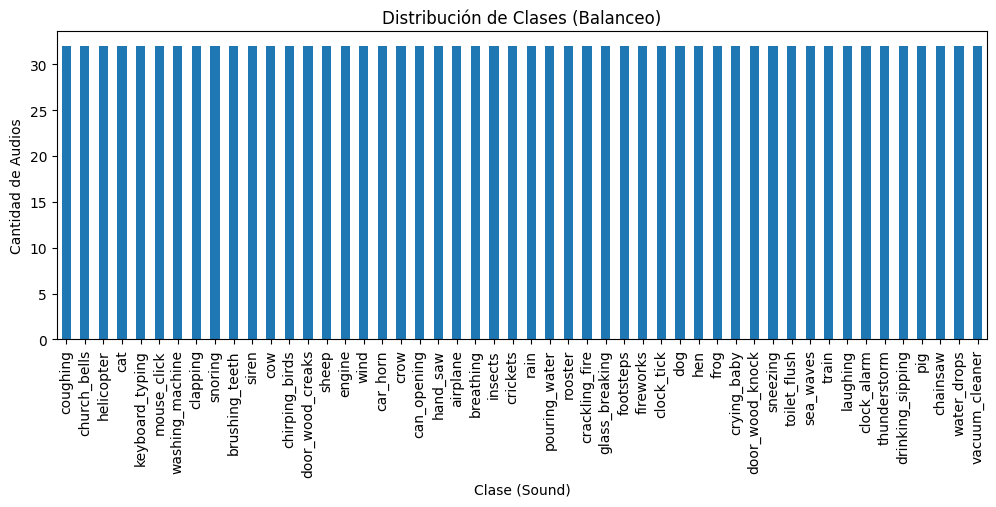

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

etiquetas = dataset['sound']
conteo = pd.Series(etiquetas).value_counts()
# Graficar
plt.figure(figsize=(12, 4))
conteo.plot(kind='bar')
plt.title('Distribución de Clases (Balanceo)')
plt.xlabel('Clase (Sound)')
plt.ylabel('Cantidad de Audios')
plt.xticks(rotation=90)
plt.show()

In [9]:
pd.Series(etiquetas).value_counts()

coughing            32
church_bells        32
helicopter          32
cat                 32
keyboard_typing     32
mouse_click         32
washing_machine     32
clapping            32
snoring             32
brushing_teeth      32
siren               32
cow                 32
chirping_birds      32
door_wood_creaks    32
sheep               32
engine              32
wind                32
car_horn            32
crow                32
can_opening         32
hand_saw            32
airplane            32
breathing           32
insects             32
crickets            32
rain                32
pouring_water       32
rooster             32
crackling_fire      32
glass_breaking      32
footsteps           32
fireworks           32
clock_tick          32
dog                 32
hen                 32
frog                32
crying_baby         32
door_wood_knock     32
sneezing            32
toilet_flush        32
sea_waves           32
train               32
laughing            32
clock_alarm

Dataset totalmente balanceado.

In [10]:
from datasets import Audio

sampling_rate = 16000

dataset = dataset.cast_column("audio", Audio(sampling_rate=sampling_rate))
val_dataset = val_dataset.cast_column("audio", Audio(sampling_rate=sampling_rate))

# Verificación rápida
print(dataset[0]['audio']['sampling_rate'])

16000


## Feature Extraction

In [11]:
from datasets import Audio
from transformers import ASTFeatureExtractor

# --- A. Resampling Automático a 16kHz (Requerido por AST) ---
# Usamos cast_column para que sea eficiente y no sature la RAM
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
val_dataset = val_dataset.cast_column("audio", Audio(sampling_rate=16000))

# --- B. Crear Mapas de Etiquetas (Label Mapping) ---
# Usamos tus columnas 'label' (id) y 'sound' (nombre) para crear el diccionario
unique_labels = dataset.unique("label")
unique_sounds = dataset.unique("sound")

# Creamos un diccionario para saber qué número corresponde a qué sonido
# Esto es vital para que al final el modelo te diga "perro" y no "14"
id2label = {id: sound for id, sound in zip(dataset["label"], dataset["sound"])}
# Filtramos para tener solo entradas únicas (el zip anterior crea duplicados, nos quedamos con el diccionario final)
id2label = dict(sorted(id2label.items())) 
label2id = {v: k for k, v in id2label.items()}

print(f"Total clases: {len(id2label)}")
print(f"Ejemplo clase 0: {id2label[0]}")

# --- C. Feature Extraction (Convertir audio a espectrogramas) ---
feature_extractor = ASTFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

def preprocess_function(examples):
    # Extraemos el array de audio de la columna 'audio'
    audio_arrays = [x["array"] for x in examples["audio"]]
    
    inputs = feature_extractor(
        audio_arrays, 
        sampling_rate=16000, 
        padding="max_length", 
        return_tensors="pt"
    )
    return inputs

# Aplicamos la transformación
# Mantenemos la columna 'label' porque el Trainer la necesita para calcular la pérdida
encoded_dataset = dataset.map(preprocess_function, remove_columns=["audio", "sound"], batched=True)
encoded_val_dataset = val_dataset.map(preprocess_function, remove_columns=["audio", "sound"], batched=True)

# Verificamos que 'label' siga ahí
print(encoded_dataset)
# Debería salir: Features: ['label', 'input_values'], num_rows: 1600

Total clases: 50
Ejemplo clase 0: airplane
Dataset({
    features: ['label', 'input_values'],
    num_rows: 1600
})


In [12]:
! pip install evaluate


[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


## Trainer

In [19]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer
import evaluate
import numpy as np

# 1. Cargar modelo (ignorando pesos viejos para adaptar a tus 50 clases)
num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593",
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True 
)

# 2. Argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./ast-esc50-finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=4, 
    gradient_accumulation_steps=2,
    fp16=True,
    dataloader_num_workers=2,
    # ---------------------------------
    
    per_device_eval_batch_size=4,
    num_train_epochs=3,          
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1,          
    remove_unused_columns=False,
    push_to_hub=False,
)

# 3. Métrica
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

# 4. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset,
    eval_dataset=encoded_val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

# 5. Ejecutar
trainer.train()

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([50]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([50, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.256000,0.391986,0.895000
2,0.159300,0.305138,0.917500
3,0.003200,0.214209,0.950000


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}
Checkpoint destination directory ./ast-esc50-finetuned/checkpoint-400 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformer

TrainOutput(global_step=600, training_loss=0.5113597617546717, metrics={'train_runtime': 474.0553, 'train_samples_per_second': 10.125, 'train_steps_per_second': 1.266, 'total_flos': 3.254969696256e+17, 'train_loss': 0.5113597617546717, 'epoch': 3.0})

In [20]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Obtener predicciones crudas (logits)
outputs = trainer.predict(encoded_val_dataset)

# 2. Convertir logits a IDs de clase (Argmax)
y_pred = np.argmax(outputs.predictions, axis=1)
y_true = outputs.label_ids

# 3. Obtener lista de nombres de clases en orden (0, 1, 2...)
# Aseguramos que el orden coincida con los IDs
class_names = [id2label[i] for i in range(len(id2label))]

In [21]:
# Generar reporte de scikit-learn
print(classification_report(y_true, y_pred, target_names=class_names))

                  precision    recall  f1-score   support

        airplane       1.00      0.88      0.93         8
       breathing       0.88      0.88      0.88         8
  brushing_teeth       1.00      1.00      1.00         8
     can_opening       1.00      1.00      1.00         8
        car_horn       1.00      1.00      1.00         8
             cat       1.00      1.00      1.00         8
        chainsaw       1.00      1.00      1.00         8
  chirping_birds       1.00      1.00      1.00         8
    church_bells       1.00      1.00      1.00         8
        clapping       1.00      1.00      1.00         8
     clock_alarm       1.00      1.00      1.00         8
      clock_tick       1.00      1.00      1.00         8
        coughing       1.00      0.88      0.93         8
             cow       1.00      1.00      1.00         8
  crackling_fire       1.00      1.00      1.00         8
        crickets       1.00      1.00      1.00         8
            c

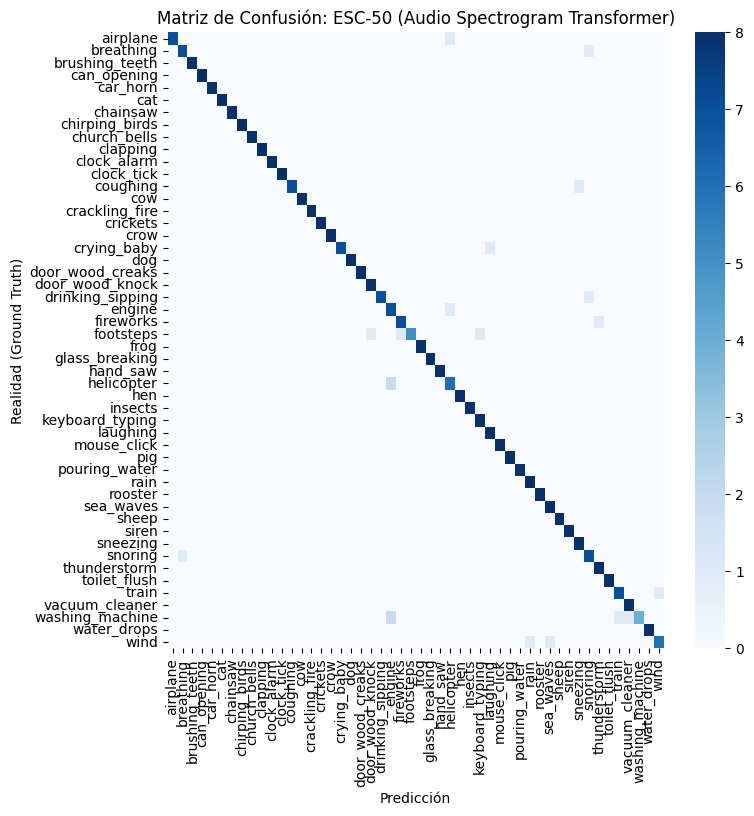

In [22]:
# Calcular la matriz
cm = confusion_matrix(y_true, y_pred)

# Graficar
plt.figure(figsize=(8, 8))
sns.heatmap(
    cm, 
    annot=False,
    fmt='d', 
    xticklabels=class_names, 
    yticklabels=class_names,
    cmap='Blues'
)
plt.xlabel('Predicción')
plt.ylabel('Realidad (Ground Truth)')
plt.title('Matriz de Confusión: ESC-50 (Audio Spectrogram Transformer)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()